In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-potability/water_potability.csv


In [2]:
df=pd.read_csv('../input/water-potability/water_potability.csv')

In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# Checking the percentage of null values

In [4]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False).round(2)

Sulfate            23.84
ph                 14.99
Trihalomethanes     4.95
Hardness            0.00
Solids              0.00
Chloramines         0.00
Conductivity        0.00
Organic_carbon      0.00
Turbidity           0.00
Potability          0.00
dtype: float64

### Co-relation map to understand the data better

<AxesSubplot:>

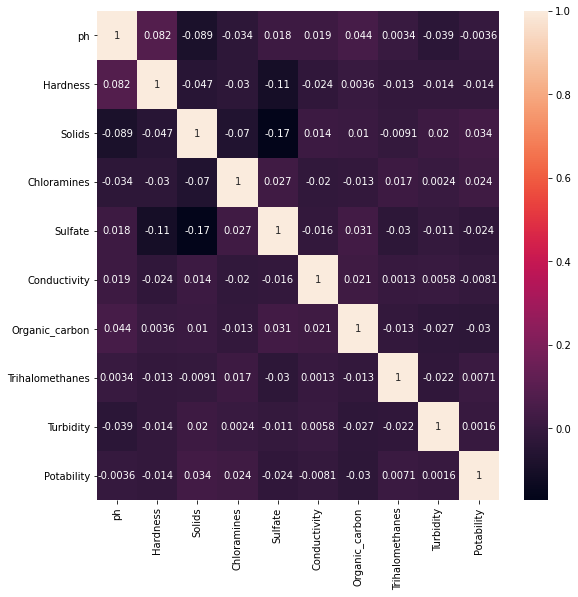

In [5]:
fig,ax=plt.subplots(figsize=(9,9))
sns.heatmap(df.corr(),annot=True)

## Approach used to fill null values:
1. **Identify the column with null values**
2. **Build Co-relation chart**
3. **Form a new data-set with one column of missing values and other positive co-related values filled data**
4. **Drop null values and Apply ML model and hyper-parameter tuning to find the best predicted value**
5. **Repeat the steps 3-4 till all the columns are filled**

In [6]:
df_sul=df[['Sulfate','Organic_carbon','Chloramines']]

### Dropping null values

In [7]:
df_sul=df_sul.dropna()

### Scaling the dataset

In [8]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scled=scaler.fit_transform(df_sul.drop('Sulfate',axis=1))

### Splitting the data

In [9]:
from sklearn.model_selection import train_test_split
x_tr,x_te,y_tr,y_te=train_test_split(scled,df_sul['Sulfate'],random_state=42,test_size=0.3)

### Importing the model to predict the values for missing column

In [10]:
from sklearn.svm import SVR
svr=SVR()

### For tuning the hyper-parameters

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2],'gamma':['scale','auto'],'C':[1.2,1.3,1.4,1.7]}
gs=GridSearchCV(svr,param_grid=param_grid,n_jobs=-1,cv=3,verbose=3)

### Fitting and predicting the data in Grid-search 

In [12]:
gs.fit(x_tr,y_tr)
sul_pr=gs.predict(x_te)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.2s finished


### Getting the column ready to be predicted

In [13]:
sulfatee=gs.predict(scaler.fit_transform(df[['Organic_carbon','Chloramines']]))

### Adding new column in dataframe

In [14]:
df['sulfatee']=sulfatee

### dropping the old column

In [15]:
df.drop('Sulfate',axis=1,inplace=True)

### Fitting data for next column

In [16]:
tr_df=df[['Chloramines','Conductivity','Potability','Trihalomethanes']]
tr_df=tr_df.dropna()
tr_sc=scaler.fit_transform(tr_df.drop('Trihalomethanes',axis=1))
tr_tr,tr_te,ytr_tr,yte_te=train_test_split(tr_sc,tr_df['Trihalomethanes'],random_state=42,test_size=0.3)
gs.fit(tr_tr,ytr_tr)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.6s finished


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1.2, 1.3, 1.4, 1.7], 'degree': [1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

### Predicting the values

In [17]:
trr=gs.predict(scaler.fit_transform(df[['Chloramines','Conductivity','Potability']]))

### Adding the data in df and dropping the old data

In [18]:
df['trr']=trr
df.drop('Trihalomethanes',axis=1,inplace=True)

### Predicting values for missing ph column

In [19]:
ph_df=df[['ph','Hardness','sulfatee','Conductivity','Organic_carbon','trr']]
ph_df.dropna(inplace=True)
ph_sc=scaler.fit_transform(ph_df.drop('ph',axis=1))
x_tr,x_te,y_tr,y_te=train_test_split(ph_sc,ph_df['ph'],random_state=42,test_size=0.3)
gs.fit(x_tr,y_tr)
phh=gs.predict(df[['Hardness','sulfatee','Conductivity','Organic_carbon','trr']])
df['phh']=phh
df.drop('ph',axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   11.7s finished


### Final data-set

In [20]:
df.head()

,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Turbidity,Potability,sulfatee,trr,phh
0,204.890455,20791.318981,7.300212,564.308654,10.379783,2.963135,0,335.408437,65.776040,-16.577468
1,129.422921,18630.057858,6.635246,592.885359,15.180013,4.500656,0,334.885796,65.547685,-39.790184
2,224.236259,19909.541732,9.275884,418.606213,16.868637,3.055934,0,332.929631,66.708051,5.480949
3,214.373394,22018.417441,8.059332,363.266516,18.436524,4.628771,0,335.033124,66.739087,9.305726
4,181.101509,17978.986339,6.546600,398.410813,11.558279,4.075075,0,335.021410,66.344148,-3.708492


In [21]:
(df.isnull().sum()/len(df)*100).round(2)

Hardness          0.0
Solids            0.0
Chloramines       0.0
Conductivity      0.0
Organic_carbon    0.0
Turbidity         0.0
Potability        0.0
sulfatee          0.0
trr               0.0
phh               0.0
dtype: float64

### Building a model to predict the Potability

In [22]:
from sklearn.svm import SVC
svc=SVC()
param_grid={'C':[1.2,1.5,2.2,3.5,3.2,4.1],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,4,8,10],'gamma':['scale','auto']}
gridsearch=GridSearchCV(svc,param_grid=param_grid,n_jobs=-1,verbose=4,cv=3)

### Scaling features

In [23]:
scaled_x=scaler.fit_transform(df.drop('Potability',axis=1))

### Splitting the final Data-set

In [24]:
x_tr,x_te,y_tr,y_te=train_test_split(scaled_x,df['Potability'],random_state=42,test_size=0.3)

In [25]:
x_tr.shape,y_tr.shape

((2293, 9), (2293,))

### Fitting The data

In [26]:
gridsearch.fit(x_tr,y_tr)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 713 out of 720 | elapsed:   22.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   22.3s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.2, 1.5, 2.2, 3.5, 3.2, 4.1],
                         'degree': [1, 2, 4, 8, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=4)

In [27]:
gridsearch.best_params_

{'C': 1.2, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

### Predicting the values with best model

In [28]:
predicted_y=gridsearch.predict(x_te)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_te,predicted_y))

[[617   0]
 [  0 366]]


### Testing the accuracy

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_te,predicted_y)

1.0

### 100% Accuracy achieved